# HW Overview

Please complete all core assignment tasks. For 50% bonus points please complete the optional stretech assignment tasks that will involve more theory and programming.

Please consult Canvas for the grading rubric (check Module 02 -> HW 02).

Broadly speaking you will be graded on the following (please consult Canvas for the final breakdown:


* Download the data  [5 points]
* Setup and perfrom Gridsearch over the hyperparameter possibilies [5 points]
* Visualize the results of gridsearch and report best model combination [5 points]
* Report perfromance on the held out test set and present Table of experimental results (for the different models) [5 points]
  * Kaggle submission and screenshot
* For optional tasks (10 points each): 
  * we will have an additional task of code review  [5 points] which will take the place of data downloading task.


# Image classification dataset: CIFAR10

In this homework, we will be using a couple of datasets. The bigger one is this Image classification dataset: CIFAR10.

** Please DOWNLOAD image DATA FROM [HERE](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) AND PUT IT TO THE DATA FOLDER** 

The [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks. Such a situation is called **multiclass** classification in oppose to **multilabel** classification when each example may have multiple label.

One can see state-of-the-art results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

In [1]:
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [3]:
np.random.seed(42)

# Upacking the Data and doing EDA
In this section we unpack the CIFAR-10 Data set and do some exploratory data analysis

Unarchive data

In [4]:
tar = tarfile.open("data/cifar-10-python.tar.gz", "r:gz")
tar.extractall("data")
tar.close()

## Reading

Data are stored as a memory dump with python $\text{dict}$ object. It was created using **pickle** function. To read one should "unpickle" it.

In [5]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin1')
    fo.close()
    return dict

Data are also splitted in to 5 pieces for conveniece. Let's read them all and concatenate

In [6]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

Read test data. In this dataset train/test split is provided by authors of the dataset to be able to consistently evaluate solutions

In [7]:
data_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

Read meta-information file with the names of the classes

In [8]:
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"]

## Pre-processing

We have too many data

In [9]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 50000
Test size: 10000


### Downsample the data so we can experiment more easily
Let's downsample (common strategy to get a POC, proof of concept working) the data by taking a random sample of 10% the training and test sets. This will  allow us to do some experiments much more quickly. **PLEASE do NOT FORGET to use all the data for Kaggle submissions**.

In [10]:
subsample_rate = 0.1

We want to preserve the same quantity ratio between classes. In python such an option is called **stratification**. Let's randomly (with fixed initial seed for the sake of reproducibility) divide part of train data

In [11]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The same for test

In [12]:
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Indeed, we preserved the number of objects of each class

In [13]:
unique_train = np.unique(y_train, return_counts=True)
list(zip(np.array(classes)[unique_train[0]], unique_train[1]))

[('airplane', 500),
 ('automobile', 500),
 ('bird', 500),
 ('cat', 500),
 ('deer', 500),
 ('dog', 500),
 ('frog', 500),
 ('horse', 500),
 ('ship', 500),
 ('truck', 500)]

## Visualization

For now each object has the following shape

In [14]:
X_train[0].shape

(3072,)

$3072 = 32 \times 32 \times 3$ where $32 \times 32$ is the size of the image in pixels and $3$ is the number of channels (RGB)

To show this array as an image let's reshape it in the needed from with the shape $(32, 32, 1)$

In [15]:
def show_pic(x):
    plt.imshow(x.reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
    plt.axis("off")

Draw one pic from each class

In [16]:
classes_idx_examples = np.zeros(10, dtype=np.int)
for i in range(10):
    classes_idx_examples[i] = np.where(y_train == i)[0][0]

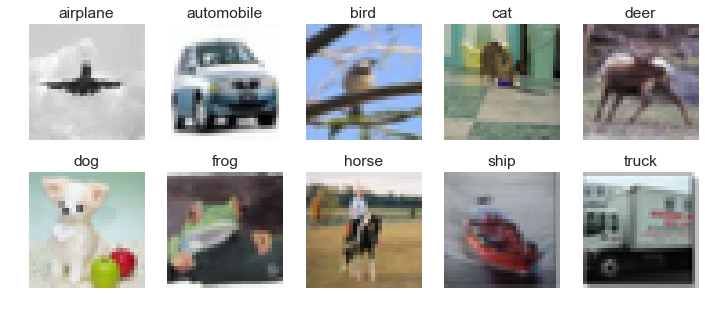

In [17]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_train[classes_idx_examples[i]])
    plt.title(classes[i])

# Build some models using SKLearning

Let's use Sklearn implementation of algorithms to build some benchmark models for image classification.

Also one should **always** track the results of the experiments to be able to compare different approaches. Let's create pandas $\text{DataFrame}$ for this purpose.

In [18]:
results = pd.DataFrame(columns=["Model", "Test Accuracy"])

For now it is empty, but will be filled in later

In [19]:
results

,Model,Test Accuracy


## KNN

In this section the K Nearest Neighbors implementation from sklearn is presented (see theory below and in lectures)

For the beginning let's use default parametrs of KNN Sklearn classifier which are:
* $\text{n_neighbors} = 5$
* $L_2$ metric

In [20]:
# n_jobs is responsible for number of CPU cores used for computation
# -1 means use all available
model_knn_sklearn = KNeighborsClassifier(n_jobs=-1)

### Fitting

In [21]:
model_knn_sklearn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

### Evaluation

Predict answers on the test set

In [22]:
y_pred_test = model_knn_sklearn.predict(X_test)

Accuracy score with sklearn function

In [23]:
acc = accuracy_score(y_test, y_pred_test)

Append first row to the results table

In [24]:
results.loc[len(results)] = ["KNN Arbitary Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262


### Insight into predictions

Let's take one correct prediction from test set and look onto its nearest neighbors

In [25]:
correct_idx = np.where(y_pred_test == y_test)[0][0]

Get $k$ nearest neighbors via Sklearn interface (method $\text{kneighbors}$)

In [26]:
neighbors = model_knn_sklearn.kneighbors(X=[X_test[correct_idx]], return_distance=False)[0]

Let's see what examples are

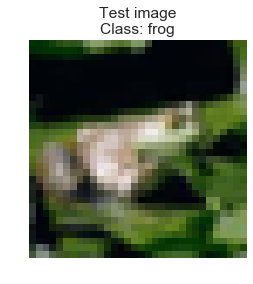

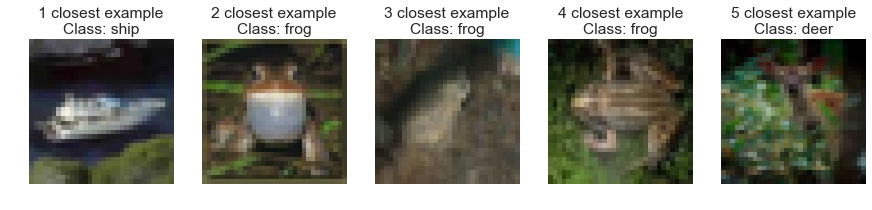

In [27]:
show_pic(X_test[correct_idx])
plt.title("Test image\nClass: " + classes[y_test[correct_idx]])
plt.show()
plt.figure(figsize=(15, 3))
for i, neighbor_idx in enumerate(neighbors):
    plt.subplot(1, 5, i + 1)
    show_pic(X_train[neighbor_idx])
    plt.title(str(i + 1) + " closest example\nClass: " + classes[y_train[neighbor_idx]])
plt.show()

Indeed, among five closest objects we have three frogs and ship pic which is very close to the initial frog pic.

It's **good** even the accuracy is bad, because our model can be explained in a very **intuitive** way

## Logistic Regression

The next thing to try is Multinomial Logistic Regression (see theory in lectures)

Here we used Sklearn $\text{SGDClassifier}$ with few options:
* $\text{loss} = \text{"log"} -$corresponds to Logistic Regression
* $\text{penalty} = \text{"none"}-$ for now we don't want to use regularization (using it should impove quality by few percents)
* $\text{max_iter} = 15 -$ the number of passes over the training data (aka epochs)
* $\text{average} = 10 -$ by default Stochastic Gradient Descent method is used. But it gitters massively (you should have observed it in LinearRegression homework). This is due to the not very good approximation of gradient (only by one example). To neglect this error we simply average gradient across last 10 steps.

In [28]:
model_lr_sklearn = SGDClassifier(loss="log", penalty="none", max_iter=15, average=10, n_jobs=-1)

### Fitting

In [29]:
model_lr_sklearn.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=10, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=15, n_iter=None,
       n_jobs=-1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

### Evaluation

Prediction

In [30]:
y_pred_test = model_lr_sklearn.predict(X_test)

Accuracy

In [31]:
acc = accuracy_score(y_test, y_pred_test)

Keeping table of results up-to-date

In [32]:
results.loc[len(results)] = ["LR Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343


$7\%$ better, not bad!

# Assignment

In order to complete this lab successfully, please review the following lab:
* `CrossvalidationAndGridSearch-Tutorial.ipynb` from Unit 02 Labs folder.


**PLEASE do NOT FORGET to use all the CIFAR-10 data for Kaggle submissions (previously we used just 10% of the data for experimentation)**.

## K Nearest Neighbors: Grid Search
Using the CIFAR-10 dataset, use the built-in Sklearn implementation of KNN classifier and find out the best set of parameters from the following range:

$$
\text{n_neighbors} \in \{1 \ldots 5\}\\
\text{p} \in \{1 \ldots 3\}
$$

where $\text{n_neighbors}$ is the number of neighbors to consider and $\text{p}$ is the order of $L_p$ metric (see explanation below)


### Sklearn  GridSearch with Cross Validation
Complete the code in this section to do the above hyperparameter tuning via SKLearn's `GridSearchCV` over the training set only. The test dataset should only be used to report your findings after you have committed to your best model(s).

Please use SKlearn KNN.

In [33]:
knn_sk = KNeighborsClassifier(n_jobs=-1)

And specify the dictionary of parameters we want to optimize along with their ranges

In [34]:
#Define parameters
n_neighbors_range = list(range(1, 6))
p_range=list(range(1, 4))
parameters = {'n_neighbors': n_neighbors_range, 'p': p_range}
print(parameters)

{'n_neighbors': [1, 2, 3, 4, 5], 'p': [1, 2, 3]}


$\text{GridSearchCV}$ function does all the stuff. There are three main arguments:
* $\text{estimator} = \text{knn_sk} -$classifier to use; KNN from sklearn defined before
* $\text{param_grid} = \text{parameters} -$parameters ranges to test
* $\text{cv} = \text{split} -$splitting iterator to use

In [36]:
%%time
best_model = GridSearchCV(estimator=knn_sk, 
                          param_grid=parameters,  
                          cv=10, 
                          refit=False,  
                          return_train_score=False)
best_model.fit(X_train, y_train)

Wall time: 1h 36min 28s


Let's retrieve best parameters

In [37]:
best_p = best_model.best_params_["p"]
best_n = best_model.best_params_["n_neighbors"]

### best_model.cv_results_ holds a lot of useful information

Please have a closer look at  

* best_model.cv_results_["param_n_neighbors"]                
* best_model.cv_results_["param_p"]
* best_model.cv_results_["mean_test_score"] 


In [38]:
# have a look at CV dictionary of results
best_model.cv_results_

{'mean_fit_time': array([ 1.30582228,  1.28700228,  1.27764227,  1.27608223,  1.29712224,
         1.28700221,  1.28700225,  1.28856227,  1.28856225,  1.29012227,
         1.28544223,  1.34004233,  1.2854423 ,  1.3088423 ,  1.28856227]),
 'mean_score_time': array([   3.56460621,    4.238308  ,  103.23720136,    3.59424634,
           4.32636766,  103.53409939,    3.59424634,    4.20888741,
         103.95038297,    3.60516641,    4.22448742,  105.1704052 ,
           3.6005863 ,    4.21512742,  104.22408309]),
 'mean_test_score': array([ 0.2946,  0.2802,  0.2532,  0.2642,  0.2458,  0.2224,  0.2882,
         0.2672,  0.2472,  0.301 ,  0.2796,  0.2506,  0.3086,  0.2778,
         0.251 ]),
 'param_n_neighbors': masked_array(data = [1 1 1 2 2 2 3 3 3 4 4 4 5 5 5],
              mask = [False False False False False False False False False False False False
  False False False],
        fill_value = ?),
 'param_p': masked_array(data = [1 2 3 1 2 3 1 2 3 1 2 3 1 2 3],
              mask = [F

In [39]:
best_model.cv_results_["param_n_neighbors"]                 
best_model.cv_results_["param_p"]
best_model.cv_results_["mean_test_score"] 

array([ 0.2946,  0.2802,  0.2532,  0.2642,  0.2458,  0.2224,  0.2882,
        0.2672,  0.2472,  0.301 ,  0.2796,  0.2506,  0.3086,  0.2778,
        0.251 ])

### Task: report any interesting aspect of best_model
Please report and discuss any interesting aspect of best_model dictionary (there is no wrong or right response here!)

### Visualize the performance metrics along each hyperparemter
Next please visualize the accuracy for each pair of parameters (Number of neighbors and $p$) as follows [Note the code cell below will help accomplish this]:

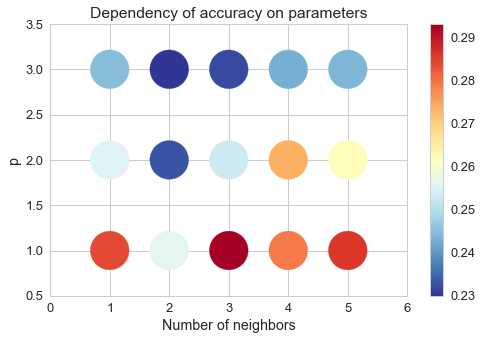

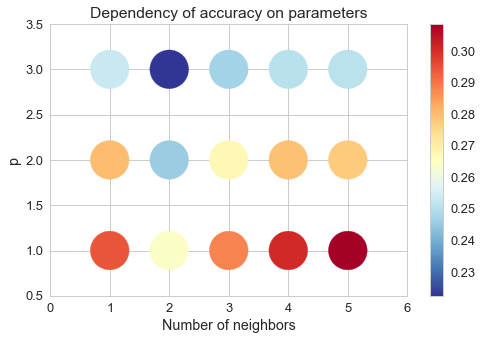

In [40]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(best_model.cv_results_["param_n_neighbors"], 
                 best_model.cv_results_["param_p"], 
                 c=best_model.cv_results_["mean_test_score"], 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid("on")
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5]);

Let's choose the best $p^*$ and see how accuracy depends on the number of nearest neightbors for a KNN classifier  $p$

In [41]:
p_idx = best_model.cv_results_["param_p"].data == best_p

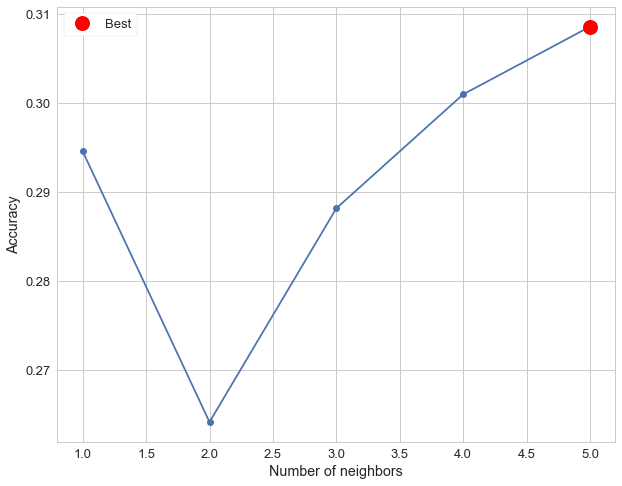

In [42]:
plt.figure(figsize=(10, 8))
plt.plot(best_model.cv_results_["param_n_neighbors"].data[p_idx], 
         best_model.cv_results_["mean_test_score"][p_idx], 
         "o-")
plt.plot([best_n], [best_model.cv_results_["mean_test_score"][p_idx][best_n - 1]], "or", markersize=15, label="Best")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("")
plt.grid("on")
plt.legend(numpoints=1)
plt.show()

Let's add this result to the table of results.

In [43]:
acc = best_model.best_score_

In [44]:
results.loc[len(results)] = ["KNN Grid Search Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309


### Sklearn Weighted KNN
In usual KNN every object from $k$ nearest neighbors is treated equally (it is called **majority voting**). But it is obvious that closer object should make bigger impact.

In this section you should not code anything again. Just see.

In [45]:
model_knn_weighted_sklearn = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=3)

In [46]:
model_knn_weighted_sklearn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=1,
           weights='distance')

In [47]:
y_pred_test = model_knn_weighted_sklearn.predict(X_test)

In [48]:
acc = accuracy_score(y_test, y_pred_test)

In [49]:
results.loc[len(results)] = ["KNN Weighted Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304


You can see that the result is the better (by $1\%$) than simple KNN with Grid Search. 

### Task
Please do Grid Search with weighted KNN and see if you can improve. Please report the accuracy on the test set.

In [51]:
model_knn_weighted_sklearn_24 = KNeighborsClassifier(n_jobs=-1, weights="distance", p=2, n_neighbors=4)
model_knn_weighted_sklearn_24.fit(X_train, y_train)
y_pred_test = model_knn_weighted_sklearn_24.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
results.loc[len(results)] = ["KNN Weighted Sklearn_p=2_n=4", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304
4,KNN Weighted Sklearn_p=2_n=4,0.300


In [52]:
model_knn_weighted_sklearn_14 = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=4)
model_knn_weighted_sklearn_14.fit(X_train, y_train)
y_pred_test = model_knn_weighted_sklearn_14.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
results.loc[len(results)] = ["KNN Weighted Sklearn_p=1_n=4", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304
4,KNN Weighted Sklearn_p=2_n=4,0.300
5,KNN Weighted Sklearn_p=1_n=4,0.295


In [53]:
model_knn_weighted_sklearn_15 = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=5)
model_knn_weighted_sklearn_15.fit(X_train, y_train)
y_pred_test = model_knn_weighted_sklearn_15.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
results.loc[len(results)] = ["KNN Weighted Sklearn_p=1_n=5", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304
4,KNN Weighted Sklearn_p=2_n=4,0.300
5,KNN Weighted Sklearn_p=1_n=4,0.295
6,KNN Weighted Sklearn_p=1_n=5,0.299


In [54]:
model_knn_weighted_sklearn_16 = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=6)
model_knn_weighted_sklearn_16.fit(X_train, y_train)
y_pred_test = model_knn_weighted_sklearn_16.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
results.loc[len(results)] = ["KNN Weighted Sklearn_p=1_n=6", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304
4,KNN Weighted Sklearn_p=2_n=4,0.300
5,KNN Weighted Sklearn_p=1_n=4,0.295
6,KNN Weighted Sklearn_p=1_n=5,0.299
7,KNN Weighted Sklearn_p=1_n=6,0.281


In [55]:
model_knn_weighted_sklearn_26 = KNeighborsClassifier(n_jobs=-1, weights="distance", p=2, n_neighbors=6)
model_knn_weighted_sklearn_26.fit(X_train, y_train)
y_pred_test = model_knn_weighted_sklearn_26.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
results.loc[len(results)] = ["KNN Weighted Sklearn_p=2_n=6", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304
4,KNN Weighted Sklearn_p=2_n=4,0.300
5,KNN Weighted Sklearn_p=1_n=4,0.295
6,KNN Weighted Sklearn_p=1_n=5,0.299
7,KNN Weighted Sklearn_p=1_n=6,0.281
8,KNN Weighted Sklearn_p=2_n=6,0.279


In [56]:
model_knn_weighted_sklearn_25 = KNeighborsClassifier(n_jobs=-1, weights="distance", p=2, n_neighbors=5)
model_knn_weighted_sklearn_25.fit(X_train, y_train)
y_pred_test = model_knn_weighted_sklearn_25.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
results.loc[len(results)] = ["KNN Weighted Sklearn_p=2_n=5", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304
4,KNN Weighted Sklearn_p=2_n=4,0.300
5,KNN Weighted Sklearn_p=1_n=4,0.295
6,KNN Weighted Sklearn_p=1_n=5,0.299
7,KNN Weighted Sklearn_p=1_n=6,0.281
8,KNN Weighted Sklearn_p=2_n=6,0.279
9,KNN Weighted Sklearn_p=2_n=5,0.288


In [57]:
model_knn_weighted_sklearn_23 = KNeighborsClassifier(n_jobs=-1, weights="distance", p=2, n_neighbors=3)
model_knn_weighted_sklearn_23.fit(X_train, y_train)
y_pred_test = model_knn_weighted_sklearn_23.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
results.loc[len(results)] = ["KNN Weighted Sklearn_p=2_n=3", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304
4,KNN Weighted Sklearn_p=2_n=4,0.300
5,KNN Weighted Sklearn_p=1_n=4,0.295
6,KNN Weighted Sklearn_p=1_n=5,0.299
7,KNN Weighted Sklearn_p=1_n=6,0.281
8,KNN Weighted Sklearn_p=2_n=6,0.279
9,KNN Weighted Sklearn_p=2_n=5,0.288


In [60]:
model_knn_uniform_sklearn_15 = KNeighborsClassifier(n_jobs=-1, weights="uniform", p=1, n_neighbors=5)
model_knn_uniform_sklearn_15.fit(X_train, y_train)
y_pred_test = model_knn_uniform_sklearn_15.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
results.loc[len(results)] = ["KNN uniform Sklearn_p=1_n=5", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304
4,KNN Weighted Sklearn_p=2_n=4,0.300
5,KNN Weighted Sklearn_p=1_n=4,0.295
6,KNN Weighted Sklearn_p=1_n=5,0.299
7,KNN Weighted Sklearn_p=1_n=6,0.281
8,KNN Weighted Sklearn_p=2_n=6,0.279
9,KNN Weighted Sklearn_p=2_n=5,0.288


## Try to do a submission to the Kaggle competition on [CIFAR](https://www.kaggle.com/c/cifar-10). 

Note that the training and testings set in the competition is exactly the same as in this homework. Please make



Report your nick, rank and quality in this notebook when submitting an assignment solution. Include a screenshot of your relative position on the scoreboard. ** Please note that KNN is a poor performer on this task.**

E.g., 

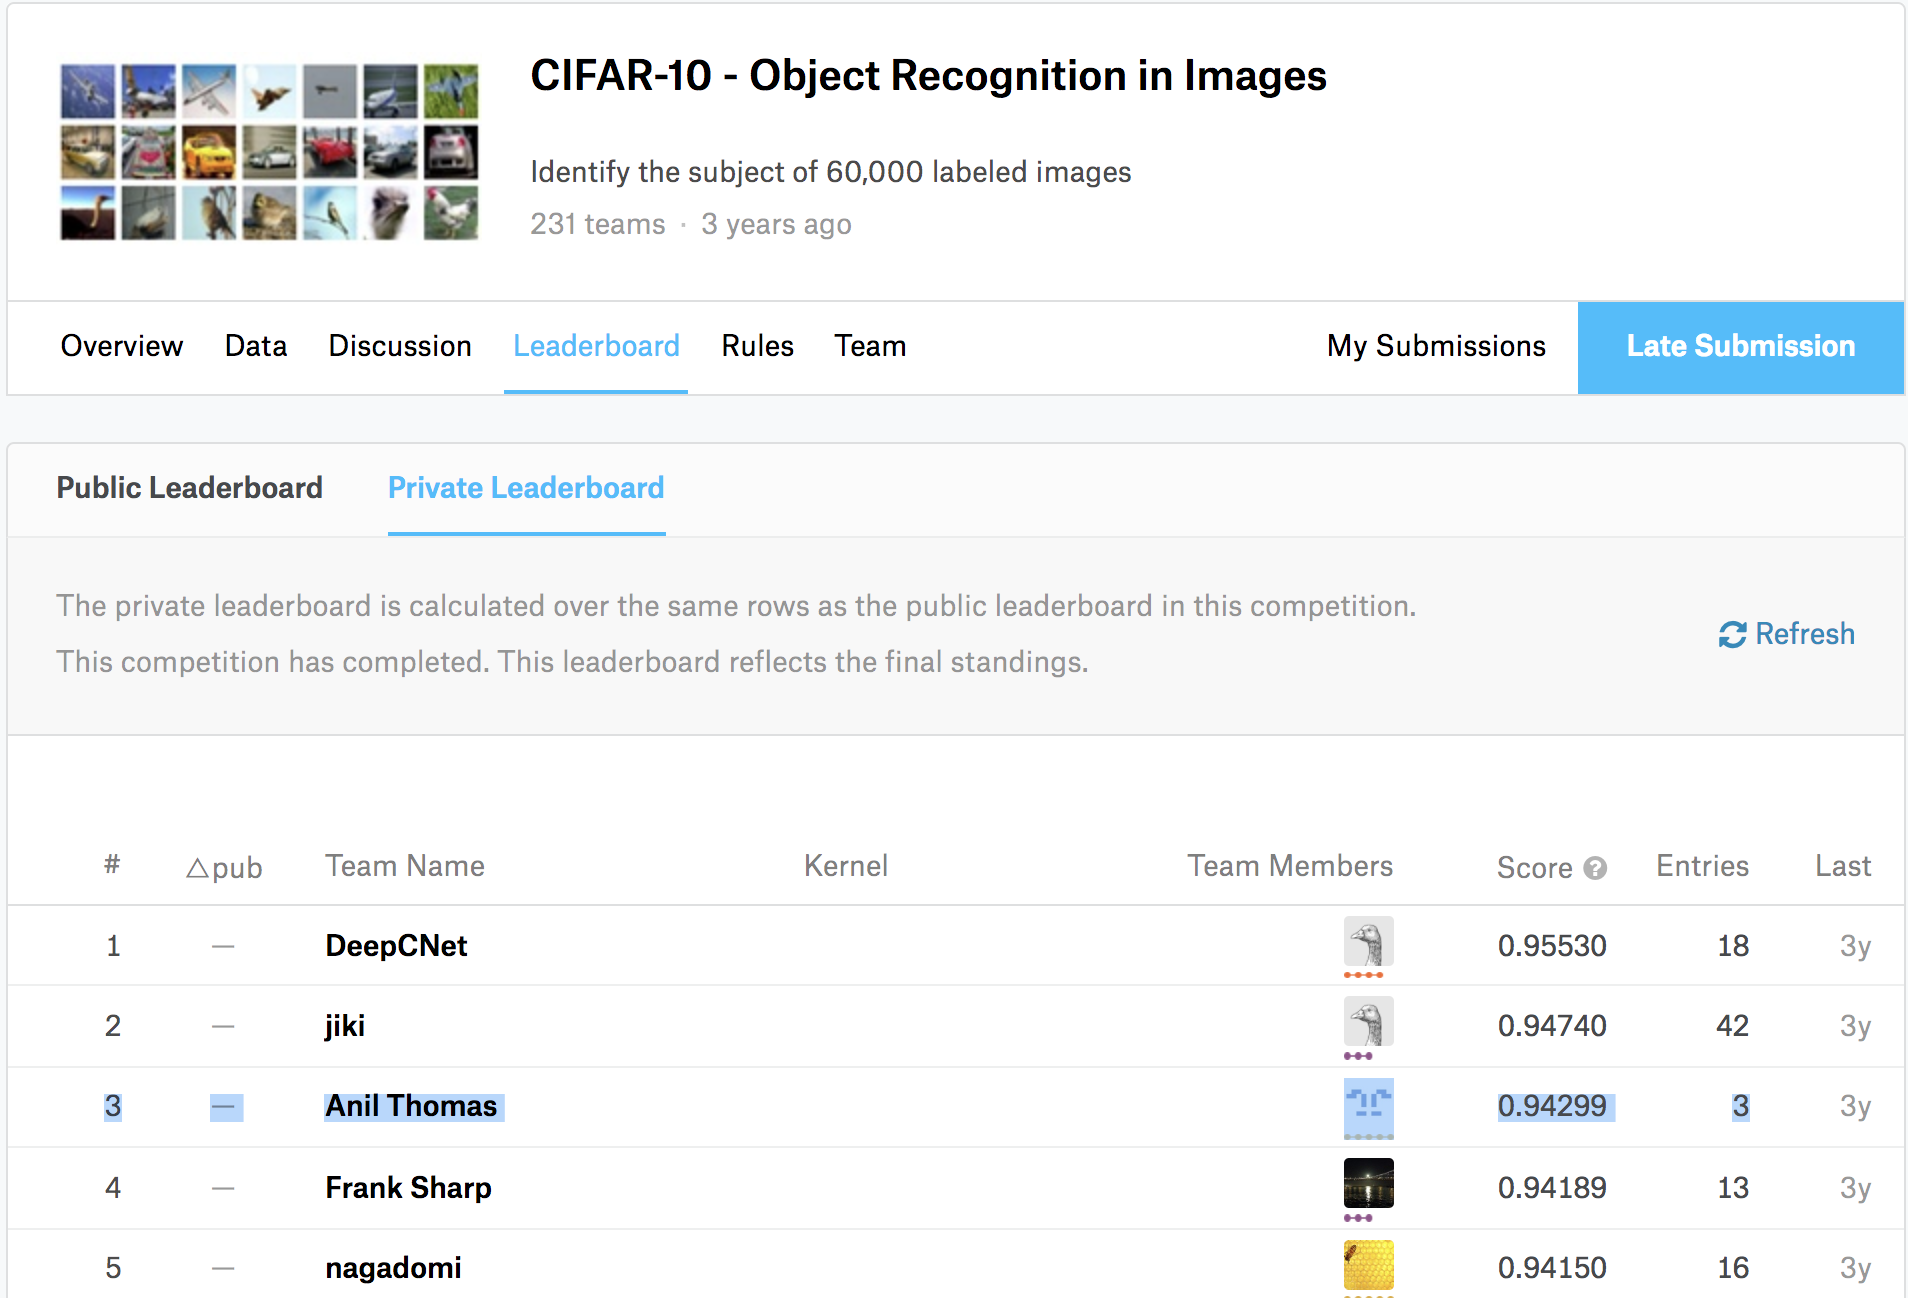

### Submission Screenshot
I tried to run this code to import image, however I encountered the problem:
RuntimeError: Imageio Pillow plugin requires Pillow lib.
I tried a lot of ways to fix it but it still does not work. My platform is windows 7, Anaconda Jupyter Notebook.
(I wanted to install docker however so far my laptop does not support to install docker since it requires windwos 10 pro. And I am in China now, so it was difficult for me to use google juypter as well).
I might will buy a new laptop if I encounter similar problem in the future.
So here I tried to submit ramdon submission to be familar with Kaggle submission:

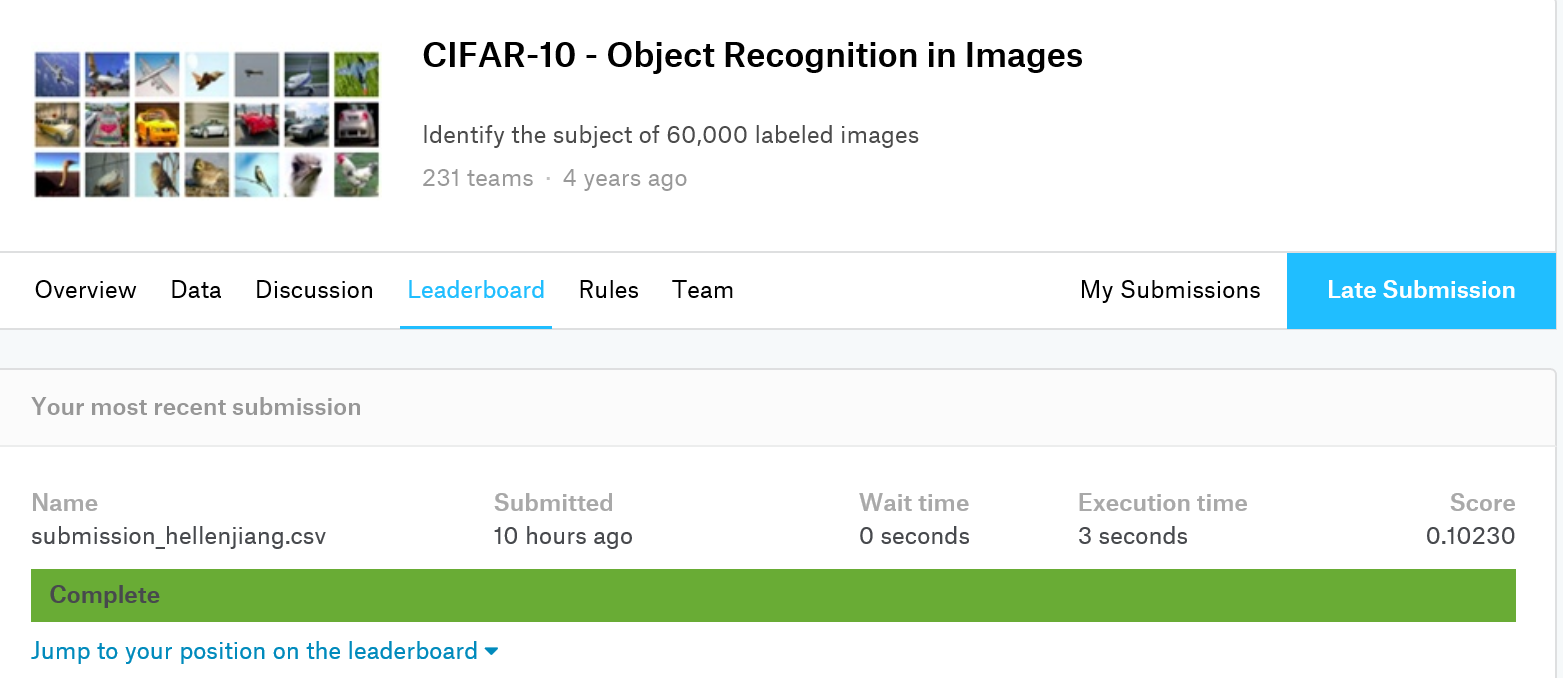

# Assignment: KNN Regression



## Task: KNN regression model for the Boston housing data

Using SKLearn's implemention of KNN, determine a good KNN regression model for the Boston housing data

* put 20% of the data aside as a random test that should not be used during training (and it should be not during hyperparameter tuning). Please use it to report MSE (Mean squared error) on the model your deem best after hyperparameter tuning via GridSearch. 

In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
import matplotlib
import matplotlib.pyplot as plt

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load boston housing price data
from sklearn.datasets import load_boston
boston = load_boston()
print("Data shape: {}".format(boston.data.shape))

Data shape: (506, 13)


In [3]:
#learn more about the Boston dataset
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [4]:
#obtain features data and target data
X = boston.data
y = boston.target

In [6]:
# split the data into training and a heldout (aka blind) test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 404
Test size: 102


In [7]:
# define parameter grid
n_neighbors_range = list(range(1, 6))
p_range=list(range(1, 4))
weight_options = ['distance','uniform']
parameters = {'knn__n_neighbors': n_neighbors_range, 'knn__p': p_range,'knn__weights':weight_options}
#parameters = {'p': p_range,'weights':weight_options}
print(parameters)

{'knn__n_neighbors': [1, 2, 3, 4, 5], 'knn__p': [1, 2, 3], 'knn__weights': ['distance', 'uniform']}


In [8]:
# Configure the pipeline (standardize the data; build model)
pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

In [13]:
# Set up gridsearch with crossfold validation
grid_search = GridSearchCV(pipe, parameters, cv=10, scoring="neg_mean_squared_error",refit=True)

In [14]:
#Train model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5], 'knn__p': [1, 2, 3], 'knn__weights': ['distance', 'uniform']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [15]:
#examine results
print("All GRID results\n-----------------------------------------------")
cvres = grid_search.cv_results_
#cvres is a results data structure. PRINT it!  print(cvres)
#print(cvres)
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("GRID", mean_score, params)
print("\nAll GRID results\n-----------------------------------------------")
#print("grid_search.cv_results_", grid_search.cv_results_)
#estimator : estimator object. This is assumed to implement the scikit-learn estimator interface.  
#            Either estimator needs to provide a score function, or scoring must be passed.
#Accuracy is the default for classification; feel free to change this to precision, recall, fbeta
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(grid_search.best_params_.keys()):
    print("\t%s: %r" %(param_name, best_parameters[param_name]))


All GRID results
-----------------------------------------------
GRID -23.1682178218 {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'distance'}
GRID -23.1682178218 {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}
GRID -21.1758168317 {'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'distance'}
GRID -21.1758168317 {'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'uniform'}
GRID -21.8606683168 {'knn__n_neighbors': 1, 'knn__p': 3, 'knn__weights': 'distance'}
GRID -21.8606683168 {'knn__n_neighbors': 1, 'knn__p': 3, 'knn__weights': 'uniform'}
GRID -18.0980256574 {'knn__n_neighbors': 2, 'knn__p': 1, 'knn__weights': 'distance'}
GRID -19.0935519802 {'knn__n_neighbors': 2, 'knn__p': 1, 'knn__weights': 'uniform'}
GRID -17.8743555475 {'knn__n_neighbors': 2, 'knn__p': 2, 'knn__weights': 'distance'}
GRID -18.6632425743 {'knn__n_neighbors': 2, 'knn__p': 2, 'knn__weights': 'uniform'}
GRID -18.8605807825 {'knn__n_neighbors': 2, 'knn__p': 3, 'knn__weights': 'distance'}
GRID 

Next please visualize the MSE for each pair of parameters (Number of neighbors and $p$) as follows:

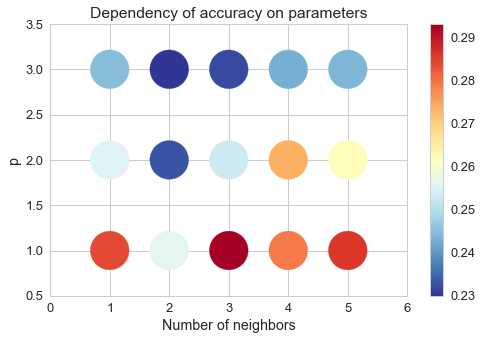

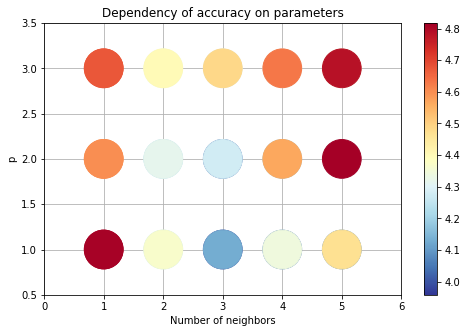

In [16]:
#Visualize the MSE for each pair of parameters(number of neighbors and p)
plt.figure(figsize=(8, 5))

sc = plt.scatter(grid_search.cv_results_["param_knn__n_neighbors"], 
                 grid_search.cv_results_["param_knn__p"], 
                 c=np.sqrt(-grid_search.cv_results_["mean_test_score"]), 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5])
plt.show()

In [21]:
#Report best parameters,MSE,RMSE
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(grid_search.best_params_.keys()):
    print("\t%s: %r" %(param_name, best_parameters[param_name]))
best_n=best_parameters['knn__n_neighbors']
best_p=best_parameters['knn__p']
best_weights=best_parameters['knn__weights']
    
model_knn_weighted_regressor = KNeighborsRegressor(n_jobs=-1, weights=best_weights, p=best_p, n_neighbors=best_n)
model_knn_weighted_regressor.fit(X_train, y_train)
y_pred_test = model_knn_weighted_regressor.predict(X_test)
MSE = np.power(y_test - y_pred_test,2).mean()
print ("The MSE for test set is:",np.round(MSE,2))
RMSE=np.round(np.sqrt(MSE),2)
print ("The RMSE for test set is:",RMSE)

Best parameters set:
	knn__n_neighbors: 3
	knn__p: 1
	knn__weights: 'distance'
The MSE for test set is: 23.58
The RMSE for test set is: 4.86


# Optional Assignment: K Nearest Neighbors from scratch

Implement K Nearest Neighbors classifier from scratch with the Class provided and do experiments on the CIFAR-10 dataset (from Section 4):

* Take the best parameters from section 4.1 
* Train a classifier
* Report a quality and discuss any differences with the SKLearn implemenentation



K Nearest Neighbors classier is the simplest **metric** classifier. The idea behind it is to find $k$ most *similar* objects and make a classification decision based on them.

To formalize the notion of similarity one should introduce the measure of the difference. Here we're going to use $L_p$ norm and induced metric.

$$
d_p(\mathbf{x}_1, \mathbf{x}_2) = \|\mathbf{x}_1 - \mathbf{x}_2\|_p = \left( \sum_{j=1}^{m}\left| x_{1, \,j} - x_{2, \,j} \right|^p \right)^{1/p}
$$

There are special names for some of the $L_p$ metrics:
* $p=1$ is Manhattan distance
* $p=2$ is Euclidian distance

For other metrics one can see [here](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)

Process of learning for KNN classifier is no more than just remembering all the training examples to find the closest one later on. There are smart ways (such as [KD trees](https://en.wikipedia.org/wiki/K-d_tree)) of storing training objects to be able to find nearest one very fast (faster than simply scanning through all of them). But here you need to implement it as a simple **array**.

For the prediction the following strategy is used:
* Find $k$ closest examples from train set
* Find the most frequent label among these $k$ closest objects (if there are few labels with the same number of objects than pick any label from those)
* Assign this label to new object

In [39]:
import math
import operator
class KNNHomegrown(object):
    
    def __init__(self, n_neighbors=5, p=2):
        self.n_neighbors = n_neighbors
        self.p = p
        self._train_objects = np.array([])
        self._train_labels = np.array([])
        
    def _metric_func(self, x1, x2):
        """
        Return distance between two objects in Lp metric
        
        Args:
            x1(ndarray): first object
            x2(ndarray): second object
        Return:
            distance(float): Lp distance 
                             between x1 and x2
        """
        
        distance = 0.
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
     

        distances=pow(abs(x1-x2),self.p)
        distancepowroot=pow(distances.sum(),1/self.p)
        distance=distancepowroot
        return distance
    
    def _accuracy(self, y_true, y_pred):
        """
        Return the accuracy error measure
        
        Args:
            y_true(ndarray): true labels
            y_pred(ndarray): predicted labels
        Return:
            acc(float):      accuracy
        """
        
        acc = 0.
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        n=len(y_pred)
        for j in range(n):
            if y_pred[j]==y_true[j]:
                acc +=1
        acc=acc/float(n)        
        return acc
    
    def fit(self, X, y):
        """
        Fits the KNN classification model
        
        Args:
            X(ndarray): objects to train on
            y(ndarray): labels for each object
        Return:
            self
        """
        
        self._train_objects = np.array([])
        self._train_labels = np.array([])
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        self._train_objects=X
        self._train_labels=y
        return self
        
    def _nearest_neighbors(self, X):
        """
        Get n nearest neighbors for each object in X.
        For each object in X returns the array of n
        closest objects in train set.
        
        Args:
            X(ndarray): objects
        Return:
            nearest_indices(ndarray): array of nearest 
                                      objects indices
        """
        
        nearest_indices = np.zeros(shape=(X.shape[0], 
                                          self.n_neighbors)) - 1
        
        #==================================================#
        #               Place your code here               #
        #            Hint: use self._metric_func           #
        #==================================================#
        for xi in range(len(X)):
            distance=[]
            nlength=len(self._train_objects)
            for xj in range(nlength):
                dist=self._metric_func(X[xi],self._train_objects[xj])
                distance.append((xj,dist))
            distance.sort(key=operator.itemgetter(1))
            for x in range(self.n_neighbors):
                nearest_indices[xi][x]=distance[x][0]
        
        return nearest_indices
    
    def predict(self, X):
        """
        Predict the label for new objects
        
        Args:
            X(ndarray): objects to predict
        Return:
            y(ndarray): labels for objects
        """
        
        y = np.zeros(shape=(X.shape[0],)) - 1
        
        #==================================================#
        #               Place your code here               #
        #        Hint: use self._nearest_neighbors         #
        #==================================================#
        nearestindices=self._nearest_neighbors(X)
        for i in range(len(X)):
            classvotes={}
            for j in range(self.n_neighbors):
                labelindice=int(nearestindices[i][j])
                response=self._train_labels[labelindice]
                if response in classvotes:
                    classvotes[response]+=1
                else:
                    classvotes[response]=1
            sortedvote=sorted(classvotes.items(),key=operator.itemgetter(1),reverse=True)
            y[i]=sortedvote[0][0]
        return y
    
    def score(self, X, y):
        """
        Return a dictionary which contains accuracy and Lp
        error metrics
        
        Args:
            X(ndarray):    objects to predict
            y(ndarray):    true labels for objects
        Return:
            metrics(dict): dictionary which contains metrics
        """
        
        y_pred = self.predict(X)
        
        acc = self._accuracy(y, y_pred)
        loss = self._metric_func(y, y_pred)
        
        metrics = {"acc": acc, "loss": loss}
        
        return metrics

In [40]:
model_knn_homegrown = KNNHomegrown(n_neighbors=3, p=1)
model_knn_homegrown.fit(X_train, y_train)
y_pred_test = model_knn_homegrown.predict(X_test)
acc = model_knn_homegrown._accuracy(y_test, y_pred_test)
results.loc[len(results)] = ["KNN Best Homegrown", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Best Homegrown weighted,0.219
1,KNN Best Homegrown weighted,0.219
2,KNN Best Homegrown,0.207


In [ ]:
#y_pred_test = model_knn_homegrown.predict(X_test)

Check that your implementation gives the same result as Sklearn. There is no randomness in this algorithm so the answer should be almost the same.

# Optional Assignment:  K Weighted Nearest Neighbors

## Vanilla KNN using majority voting
For a classification task using KNN, where K > 1, a majority voting can be thought of as the following: let's assign weight $1$ to each of the $K$ neighbors of the test case  and then just sum up the  weights for each class assign the majority class to the label of the test case. In the case of a draw, we can  randomly select a class based upon unform sampling.

## Weight KNN
Rather than assignment a  equal weight of $1$ to each nearest neighbor, let's assume that weight of each object is **inversly proporional** to the distance to test case. It means that the smaller the distance is the more the weight will be $-$ exactly that we want. The classification is done with the same rule $-$ we just sum up weights for each class and choose the class with the largest weight. 

We can follow a similar strategy for KNN Regression.

## Task: implement a weighted  KNN for classification
Implement a weighted  KNN for classification and report your findings on the CIFAR-10 dataset

In [37]:
import math
import operator
from collections import defaultdict
class KNNWeightedHomegrown(object):
    
    def __init__(self, n_neighbors=5, p=2,weights='distance'):
        self.n_neighbors = n_neighbors
        self.p = p
        self._weights=weights
        self._train_objects = np.array([])
        self._train_labels = np.array([])
        
    def _metric_func(self, x1, x2):
        """
        Return distance between two objects in Lp metric
        
        Args:
            x1(ndarray): first object
            x2(ndarray): second object
        Return:
            distance(float): Lp distance 
                             between x1 and x2
        """
        
        distance = 0.
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
     

        distances=pow(abs(x1-x2),self.p)
        distancepowroot=pow(distances.sum(),1/self.p)
        distance=distancepowroot
        return distance
    
    def _accuracy(self, y_true, y_pred):
        """
        Return the accuracy error measure
        
        Args:
            y_true(ndarray): true labels
            y_pred(ndarray): predicted labels
        Return:
            acc(float):      accuracy
        """
        
        acc = 0.
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        n=len(y_pred)
        for j in range(n):
            if y_pred[j]==y_true[j]:
                acc +=1
        acc=acc/float(n)        
        return acc
    
    def fit(self, X, y):
        """
        Fits the KNN classification model
        
        Args:
            X(ndarray): objects to train on
            y(ndarray): labels for each object
        Return:
            self
        """
        

        #==================================================#
        #               Place your code here               #
        #==================================================#
        self._train_objects=X
        self._train_labels=y
        return self
    
    def _weight_func(self,distances):
        if self._weights=='distance':
            weights=[(1/d,y) for d,y in distances]
        elif self._weights=='uniform':
            weights=[(1,y) for d,y in distances]
        else:
            raise ValueError("weights not recognized: should be 'uniform' or 'distance'")
        return weights        
       
    def _predict_one(self, testx):
        """
        Predict the label for new objects.
        Accounts for neighbors with weights in the
        mode defined in the constructor.
        
        Args:
            X(ndarray): objects to predict
        Return:
            y(ndarray): labels for objects
        """
        
        y = np.zeros(testx.shape[0]) - 1

        #==================================================#
        #               Place your code here               #
        #            Hint: use self._metric_func           #
        #==================================================#

        distances = sorted((self._metric_func(x, testx), y) for x, y in zip(self._train_objects, self._train_labels))
       # print(distances)
        weights=self._weight_func(distances[:self.n_neighbors])
        #print(weights)
        weights_by_class = defaultdict(list)
        for d, c in weights:
            weights_by_class[c].append(d)
        #print(weights_by_class)
        y=max((sum(val), key) for key, val in weights_by_class.items())[1]        
        return y
    
    def predict(self,X):
        return [self._predict_one(x) for x in X]
    
    def score(self, X, y):
        """
        Return a dictionary which contains accuracy and Lp
        error metrics
        
        Args:
            X(ndarray):    objects to predict
            y(ndarray):    true labels for objects
        Return:
            metrics(dict): dictionary which contains metrics
        """
        
        y_pred = self.predict(X)
        
        acc = self._accuracy(y, y_pred)
        loss = self._metric_func(y, y_pred)
        
        metrics = {"acc": acc, "loss": loss}
        
        return metrics

In [38]:
model_knn_homegrown_weighted = KNNWeightedHomegrown(n_neighbors=3, p=1,weights='distance')
model_knn_homegrown_weighted.fit(X_train, y_train)
y_pred_test = model_knn_homegrown_weighted.predict(X_test)
acc = model_knn_homegrown_weighted._accuracy(y_test, y_pred_test)
results.loc[len(results)] = ["KNN Best Homegrown weighted", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Best Homegrown weighted,0.219
1,KNN Best Homegrown weighted,0.219
